In [ ]:
# !pip install -q roboflow supervision==0.25.1 
# !pip install -q peft bitsandbytes transformers==4.47.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino-py 0.4.0 requires supervision==0.6.0, but you have supervision 0.25.1 which is incompatible.
maestro 1.1.0rc3 requires supervision>=0.26.0rc4, but you have supervision 0.25.1 which is incompatible.


In [1]:
import os
id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import json
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch 
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import supervision as sv

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class TifPatchDataset(Dataset):
    def __init__(self, labels_file_path: str, image_directory_path: str, prompt: str, start : int, end : int, type : str):
        self.prompt = prompt
        self.start = start
        self.end = end
        self.type = type
        self.bg_img = []
        self.img_idx = 0
        self.labels_file_path = labels_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()
        
                
    def _find_patches(self, pil_image, absolute_bbox):

        # find image patches
        image_width, image_height = pil_image.size
        patch_size = 320
        if image_width == 640:
            overlap = 20
        elif image_width == 2560:
            overlap = 120

        slice_bboxes = []
        offsets = []
        y_max = y_min = 0

        while y_max < image_height:
            x_min = x_max = 0
            y_max = y_min + patch_size
            while x_max < image_width:
                x_max = x_min + patch_size
                if y_max > image_height or x_max > image_width:
                    xmax = min(image_width, x_max)
                    ymax = min(image_height, y_max)
                    xmin = max(0, xmax - patch_size)
                    ymin = max(0, ymax - patch_size)
                    slice_bboxes.append([xmin, ymin, xmax, ymax])
                    offsets.append([xmin, ymin])
                else:
                    slice_bboxes.append([x_min, y_min, x_max, y_max])
                    offsets.append([x_min, y_min])
                x_min = x_max - overlap
            y_min = y_max - overlap
        

        # find bbox that are within the patches
        paligemma_labels = []
        cnt = 1
        for img_patch, offset in zip(slice_bboxes, offsets):
            img_xmin = img_patch[0]
            img_ymin = img_patch[1]
            img_xmax = img_patch[2]
            img_ymax = img_patch[3]
            tmp = []
            for bbox in absolute_bbox:
                xmin = min(bbox[[1,3,5,7]])
                ymin = min(bbox[[2,4,6,8]])
                xmax = max(bbox[[1,3,5,7]])
                ymax = max(bbox[[2,4,6,8]])
                if xmin >= img_xmin and ymin >= img_ymin and xmax <= img_xmax and ymax <= img_ymax:
                    xmin = (xmin - img_xmin)/patch_size * 1024
                    ymin = (ymin - img_ymin)/patch_size * 1024
                    xmax = (xmax - img_xmin)/patch_size * 1024
                    ymax = (ymax - img_ymin)/patch_size * 1024
                    ymin, xmin, ymax, xmax = ['0'*(4-len(x))+str(x) if len(x) < 4 else x for x in [str(int(ymin)), str(int(xmin)), str(int(ymax)), str(int(xmax))] ]
                    tmp.append(f'<loc{ymin}><loc{xmin}><loc{ymax}><loc{xmax}> {self.prompt}')
            if len(tmp) == 0:
                # if cnt == 1:
                tmp.append(f'<loc0000><loc0000><loc1024><loc1024> background')
                tmp = ' ; '.join(tmp)
                img = pil_image.crop(img_patch)
                paligemma_labels.append({'image': img, 'offset': offset, 'suffix': tmp, 'prefix': f'detect {self.prompt} ; background' })
                    # cnt = 0
                self.bg_img.append(self.img_idx)
            else: # add those patches which have kilns in them
                tmp = ' ; '.join(tmp)
                # create a dictionary with PIL image in one key and its bbox in another key suffix, make sure to bring the bbox range in (0, 1024) 
                img = pil_image.crop(img_patch)
                paligemma_labels.append({'image': img, 'offset': offset, 'suffix': tmp, 'prefix': f'detect {self.prompt} ; background' })
            self.img_idx += 1
        return paligemma_labels

    def _load_entries(self): # load the bbox of all patches
        entries = []
        for image_path in sorted(glob(self.image_directory_path+'/*'))[self.start:self.end]:
            img_name = os.path.basename(image_path)
            img = Image.open(image_path)
            w, h = img.size
            label_path = os.path.join(self.labels_file_path,img_name[:-4]+'.txt')
            bbox = np.loadtxt(label_path, ndmin = 2)
            bbox = bbox*w
            entries += (self._find_patches(img, bbox))

        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image = self.entries[idx]['image']
        return image, entry

In [5]:
train_dataset = TifPatchDataset(
    labels_file_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/labels", 
    image_directory_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images",
    # image_directory_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/images',
    prompt = 'brick kilns with chimney',
    start = 0,
    end = 1,
    type = 'train'
) 

test_dataset = TifPatchDataset(
    labels_file_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/labels", 
    image_directory_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images",
    # image_directory_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/images',
    prompt = 'brick kilns with chimney',
    start = 1,
    end = 15,
    type = 'test'
) 


In [6]:
len(train_dataset), len(test_dataset)

(169, 2366)

In [7]:
import re
def parse_bbox_and_labels(detokenized_output: str):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>(\w+\s?)+\w)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    # print(d)
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)

In [8]:
sum = 0
for i in range(len(train_dataset)):
    box, label = parse_bbox_and_labels(train_dataset.entries[i]['suffix'])
    for classname in label:
        if 'background' in classname:
            sum += 1
print(f'Total number of kilns in the train set {sum}')

Total number of kilns in the train set 158


In [9]:
sum = 0
for i in range(len(test_dataset)):
    box, label = parse_bbox_and_labels(test_dataset.entries[i]['suffix'])
    for classname in label:
        if 'brick kilns with chimney' in classname:
            sum += 1
print(f'Total number of kilns in the test set {sum}')

Total number of kilns in the test set 189


In [10]:
CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")
CLASSES

['brick kilns with chimney', 'background']

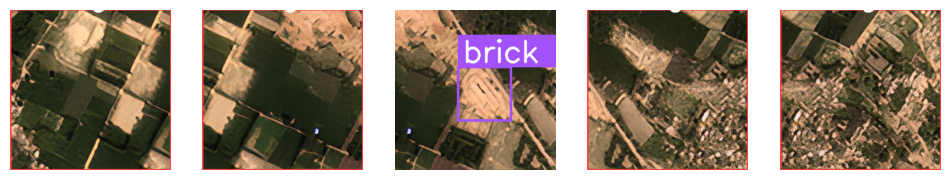

In [11]:
images = []
for i in range(5):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)
    # print(detections)
    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (1,5))

In [12]:
train_dataset.entries[0]

{'image': <PIL.Image.Image image mode=RGB size=320x320>,
 'offset': [0, 0],
 'suffix': '<loc0000><loc0000><loc1024><loc1024> background',
 'prefix': 'detect brick kilns with chimney ; background'}

In [5]:
MODEL_ID ="google/paligemma2-3b-pt-448"
# MODEL_ID = 'google/paligemma2-10b-pt-448' # on single GPU, it can not be loaded
# MODEL_ID = 'google/paligemma2-3b-mix-448'
# MODEL_ID = 'google/paligemma-3b-ft-rsvqa-lr-448'
# MODEL_ID = 'google/paligemma-3b-ft-rsvqa-hr-448'


In [7]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)
processor.tokenizer

GemmaTokenizerFast(name_or_path='google/paligemma2-3b-pt-448', vocab_size=257152, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<image>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_word=False, normaliz

In [15]:
# @title Freeze the image encoder


# TORCH_DTYPE = torch.bfloat16

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [16]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto", quantization_config= bnb_config, torch_dtype= torch.bfloat16)
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


### Fine-tune PaliGemma2 on custom object detection dataset

In [17]:
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=100,
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=1, # weights and biases logging step
    logging_strategy = 'epoch',
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,  # checkpoint is saved after every 1000 steps
    save_total_limit=1,
    output_dir="paligemma2_object_detection", # model predictions and checkpoint will be present
    bf16=True,
    # report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    # eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shataxi-dubey (shataxi). Use `wandb login --relogin` to force relogin


Step,Training Loss
2,4.851300
4,4.827400
6,4.761900
8,4.614500
10,4.435300
12,4.202000
14,3.940200
16,3.677500
18,3.402100
20,3.135800


TrainOutput(global_step=200, training_loss=0.8231015330553055, metrics={'train_runtime': 3386.8511, 'train_samples_per_second': 4.99, 'train_steps_per_second': 0.059, 'total_flos': 2.527246910050583e+17, 'train_loss': 0.8231015330553055, 'epoch': 99.74418604651163})

### Run inference with fine-tuned PaliGemma2 model

In [19]:
model.save_pretrained('my_pretrained')

In [20]:
processor.save_pretrained('my_pretrained_processor')

[]

In [22]:
model = PaliGemmaForConditionalGeneration.from_pretrained('my_pretrained', device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
processor = PaliGemmaProcessor.from_pretrained('my_pretrained_processor')

In [24]:
# TORCH_DTYPE = model.dtype
# TORCH_DTYPE

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Suffix <loc0369><loc0403><loc0709><loc0738> brick kilns with chimney
Predicted <loc0000><loc0000><loc1024><loc1024> background ; <loc0000><loc0000><loc1024><loc1024> background ; <loc0369><loc0403><loc0709><loc0737> brick kilns with chimney


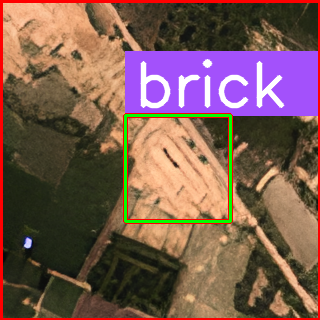

In [25]:
image, label = train_dataset[2]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]
print(f'Suffix {suffix}')
inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(f'Predicted {decoded}')

w, h = image.size
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator(thickness = 4, color = sv.Color(r=255, g= 0, b= 0)).annotate(annotated_image, detections)
# annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=suffix,
    resolution_wh=(w, h),
    classes=CLASSES)
annotated_image = sv.BoxAnnotator(thickness = 2, color = sv.Color(r=0, g= 255, b= 0)).annotate(annotated_image, detections)
annotated_image

## Evaluate finetuned PaliGemma2 Model

In [26]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

  0%|          | 11/2366 [02:32<9:05:54, 13.91s/it]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe5402d03d0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fe5885ab6d0, execution_count=26 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7fe570535550, raw_cell="import numpy as np
from tqdm import tqdm

images =.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a2252616d616e756a616e227d/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_finetune_roboflow.ipynb#X40sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.0452
mAP @ 50:    0.0890
mAP @ 75:    0.0329
mAP scores: [0.08899224 0.07197616 0.06120766 0.04835605 0.04135448 0.03290029
 0.02731672 0.02670191 0.02640712 0.02637579]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [1.12141176e-01 9.12007408e-02 6.96637362e-02 4.39605061e-02
 2.99573688e-02 1.30489881e-02 1.88185372e-03 6.52231358e-04
 6.26644943e-05 0.00000000e+00]
  1: [0.06584331 0.05275158 0.05275158 0.05275158 0.05275158 0.05275158
 0.05275158 0.05275158 0.05275158 0.05275158]

Small objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
    No results
  
Medium objects:
  MeanAveragePrecisionResult:
  Metric tar

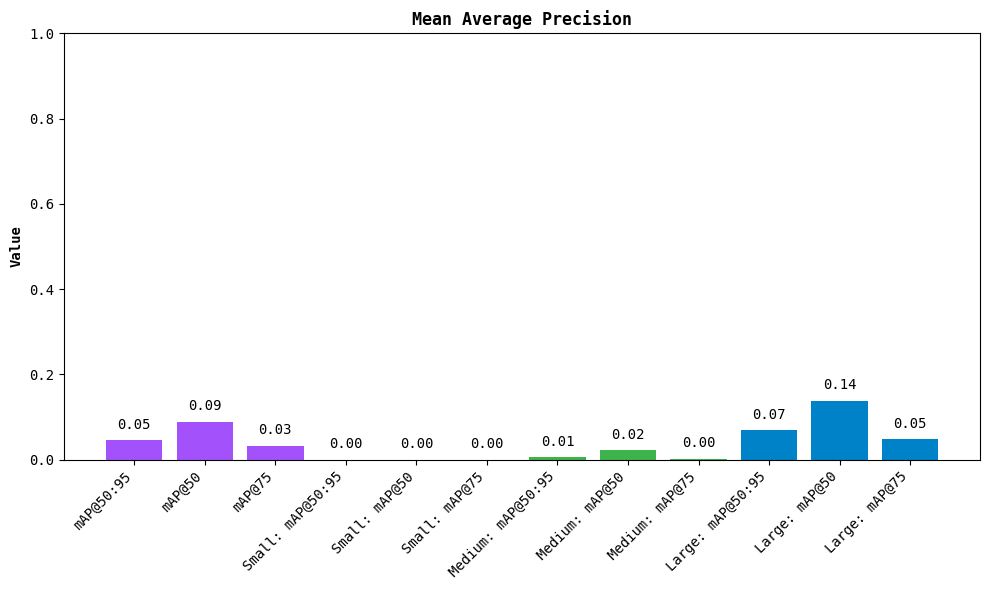

In [ ]:
map_result.plot()

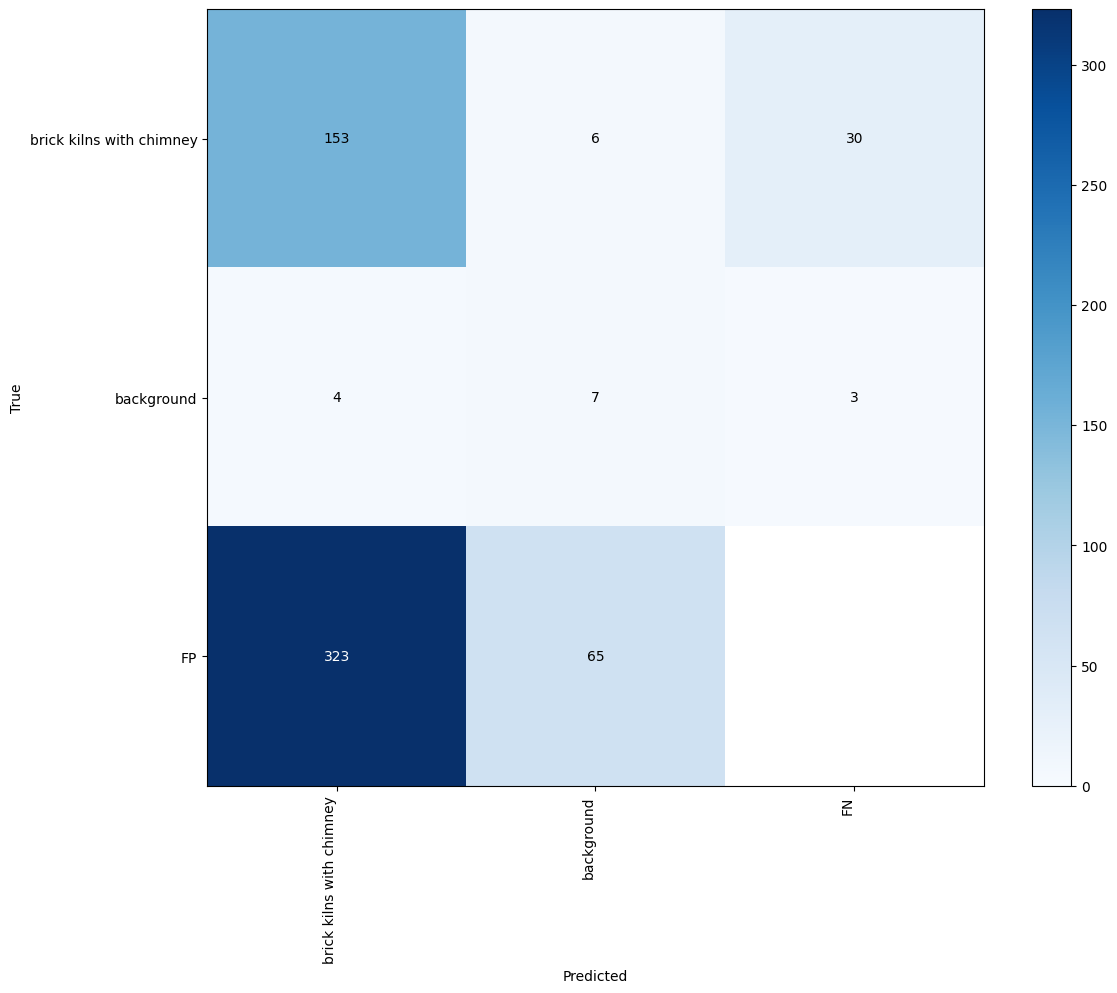

In [ ]:
# @title Calculate Confusion Matrix
# what is the IoU threshold while computing confusion matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES,
    iou_threshold=0.1
)

_ = confusion_matrix.plot()

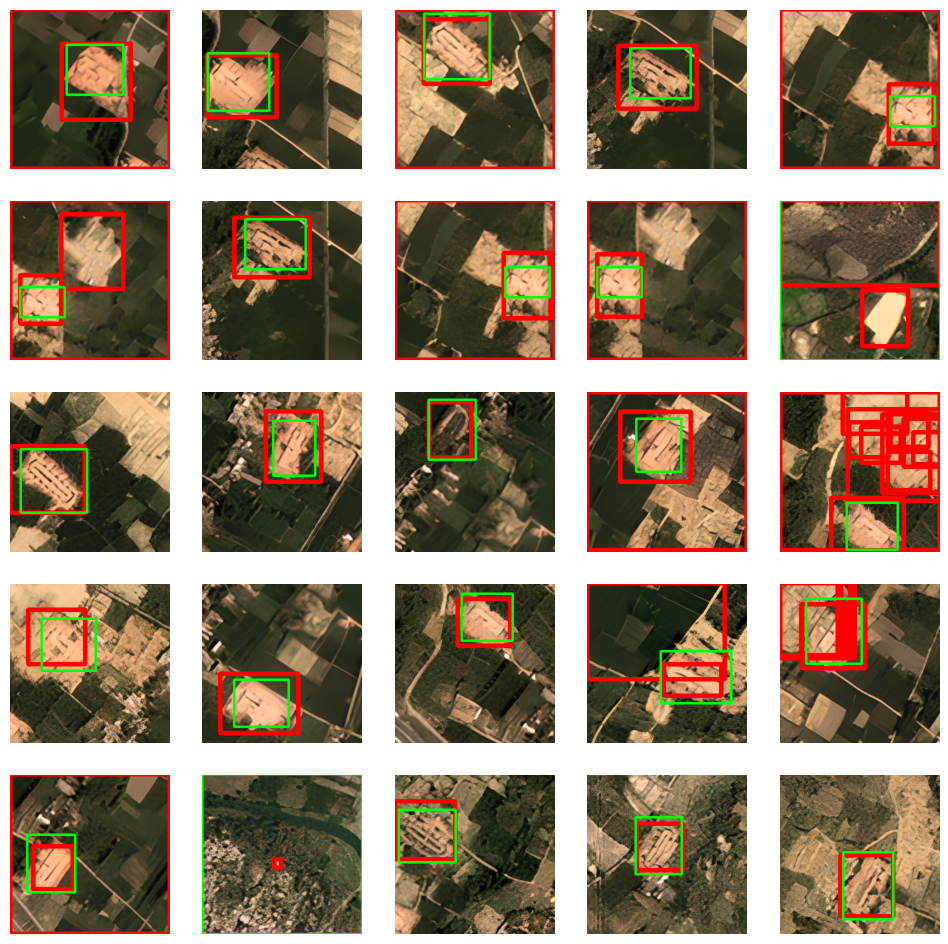

In [ ]:
annotated_images = []

for i in range(158,183):
    image = images[i]
    detections = predictions[i]
    target = targets[i]
    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=8, color=sv.Color(r=255, g=0, b=0)).annotate(annotated_image, detections)
    annotated_image = sv.BoxAnnotator(thickness=4, color=sv.Color(r=0, g=255, b=0)).annotate(annotated_image, target)
    # annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5,5))

In [ ]:
sum = 0
for pred in predictions:
    for classname in pred.data['class_name']:
        if 'background' == classname:
            sum += 1

print(sum)

78


In [ ]:
sum = 0
for pred in predictions:
    for classname in pred.data['class_name']:
        if 'brick kilns with chimney' == classname:
            sum += 1

print(sum)

480


In [ ]:
sum = 0
for target in targets:
    for classname in target.data['class_name']:
        if 'brick kilns with chimney' == classname:
            sum += 1
            # print(pred.data['class_name'])
print(sum)

189


In [ ]:
sum = 0
for target in targets:
    for classname in target.data['class_name']:
        if 'background' == classname:
            sum += 1
            # print(pred.data['class_name'])
print(sum)

14
